# Setup for google colab
The file system there works different (cwd is not the same)

In [76]:
import os
import sys

import torch

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB and not "dida_test" in os.listdir(os.getcwd()):
    !git clone https://github.com/michelj5/dida_test

DATA_PATH = os.path.join(os.getcwd(), 'dida_test', 'data') if IN_COLAB else os.path.join(os.getcwd(), 'data')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# Dataset and Data loading

* custom dataset
* data augmentation

In [106]:
import torch
from torch.utils.data import Dataset
import os


class LocalImageDataset(Dataset):
    def __init__(self, root_dir, test=False, transform=None, indices=None):
        self.test = test
        self.root_dir = root_dir

        # Assume that the images missing labels are the last 5 (this is the case for the given data)
        self.image_names = sorted(os.listdir(os.path.join(root_dir, 'images')))
        self.label_names = sorted(os.listdir(os.path.join(root_dir, 'labels')))
        if not self.test:
            self.image_names = np.array([name for name in self.image_names if name in self.label_names])
            self.label_names = np.array(self.label_names)
        else:
            self.image_names = np.array([name for name in self.image_names if name not in self.label_names])
            self.label_names = None

        if indices is not None:
            self.image_names = self.image_names[indices]
            self.label_names = self.label_names[indices] if self.label_names is not None else None

        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, 'images', self.image_names[idx])
        image = Image.open(image_name).convert("RGB")
        label = None
        if not self.test:
            label_name = os.path.join(self.root_dir, 'labels', self.label_names[idx])
            label = Image.open(label_name).convert("L")

        if self.transform:
            image, label = self.transform(image, label)

        return image, label

In [78]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader

train_dataset = LocalImageDataset(DATA_PATH,
                                  transform=v2.Compose([
                                      v2.ToImage(),
                                      v2.ToDtype(torch.float32, scale=True),
                                      v2.RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0), antialias=True),
                                      v2.RandomHorizontalFlip(p=0.5),
                                      v2.RandomVerticalFlip(p=0.5),
                                  ]),
                                  )
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = LocalImageDataset(DATA_PATH, transform=None, test=True)
# Never trust 5 * 5 = 25
# for (img, label) in train_dataloader:
#   print(img.size())
#   print(label.size())
#
# for (img, label) in train_dataset:
#     print(type(img), type(label))

# Metrics for evaluation

* f1, iou, accuracy

In [79]:
from collections import namedtuple

# [true / false] [positive / negative]
Stats = namedtuple("Stats", "tp fp tn fn")


def get_stats(output: torch.Tensor, target: torch.Tensor, threshold: float):
    """
    Computes amount of true/false positives/negatives in a prediction given the label.
    Assumes 4D input tensors.
    :param output:
    :param target:
    :param threshold:
    :return:
    """
    output = torch.where(output > threshold, 1.0, 0.0).squeeze(dim=1)
    target = target.squeeze(dim=1)
    true_pos = ((output == 1) & (target == 1)).sum(dim=(1, 2))
    false_pos = ((output == 1) & (target == 0)).sum(dim=(1, 2))
    true_neg = ((output == 0) & (target == 0)).sum(dim=(1, 2))
    false_neg = ((output == 0) & (target == 1)).sum(dim=(1, 2))

    return Stats(true_pos, false_pos, true_neg, false_neg)


def iou(stats: Stats):
    """
        Intersection over Union score.
        When evaluated on a batch of images this should result in the average scores weighted by the size of the union for each image.
    """
    return stats.tp / (stats.tp + stats.fn + stats.fp)


def f1(stats: Stats):
    """
        F1 score.
        When evaluated on a batch of images something funny might happen idk.
    """

    precision = stats.tp / (stats.tp + stats.fp)
    recall = stats.tp / (stats.tp + stats.fn)
    f1 = 2 * precision * recall / (precision + recall)
    return f1.nan_to_num()


def pixel_accuracy(stats: Stats):
    """
        Pixel accuracy (correctly classified pixels over total pixels).
        When evaluated on a batch of images this is the unweighted average of all scores.
    """
    return (stats.tp + stats.tn) / (stats.tp + stats.tn + stats.fp + stats.fn)


x = torch.tensor([[[[1, 0],
                    [0, 1],
                    [0, 0]]],

                  [[[1, 1],
                    [1, 1],
                    [1, 1]]]])

y = torch.tensor([[[[1, 1],
                    [1, 1],
                    [1, 1]]],

                  [[[1, 1],
                    [1, 1],
                    [1, 1]]]])

stats = get_stats(x, y, 0.5)
print(stats)
print(iou(stats), f1(stats), pixel_accuracy(stats))

Stats(tp=tensor([2, 6]), fp=tensor([0, 0]), tn=tensor([0, 0]), fn=tensor([4, 0]))
tensor([0.3333, 1.0000]) tensor([0.5000, 1.0000]) tensor([0.3333, 1.0000])


# Model and Training

* U-Net
* parameter search?

In [80]:
import torch.nn as nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(
                    x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True
                )

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        return x


## Training on 20 datapoints and use 5 for test

In [81]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import numpy as np

test_indices = np.arange(5)
train_indices = np.arange(5, 25)

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), antialias=True),
                        v2.RandomHorizontalFlip(p=0.5), v2.RandomVerticalFlip(p=0.5), ])

train_dataset = LocalImageDataset(DATA_PATH,
                                  transform=transform,
                                  indices=train_indices
                                  )
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = LocalImageDataset(DATA_PATH,
                                 transform=transform,
                                 indices=test_indices
                                 )
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)



Training: 100%|██████████| 64/64 [00:26<00:00,  2.46it/s]
C:\Users\julia\AppData\Local\Temp\ipykernel_44708\1084299252.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Training: 100%|██████████| 64/64 [00:50<00:00,  1.26it/s]


{(2.5e-05, 2): (0.6301441192626953, 55), (2.5e-05, 3): (0.6709682941436768, 59), (2.5e-05, 4): (0.6557168006896973, 43), (2.5e-05, 5): (0.7456238269805908, 55), (0.0001, 2): (0.6396317481994629, 35), (0.0001, 3): (0.6974816799163819, 55), (0.0001, 4): (0.7052855968475342, 63), (0.0001, 5): (0.7222916603088378, 63), (0.0004, 2): (0.6696581840515137, 15), (0.0004, 3): (0.693194580078125, 31), (0.0004, 4): (0.7233768463134765, 47), (0.0004, 5): (0.6412225723266601, 59)}


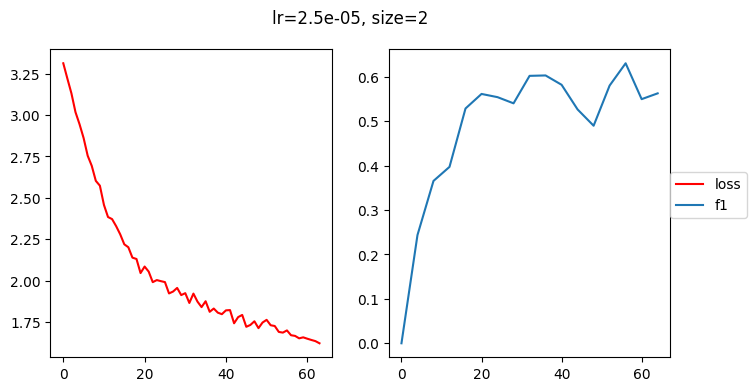

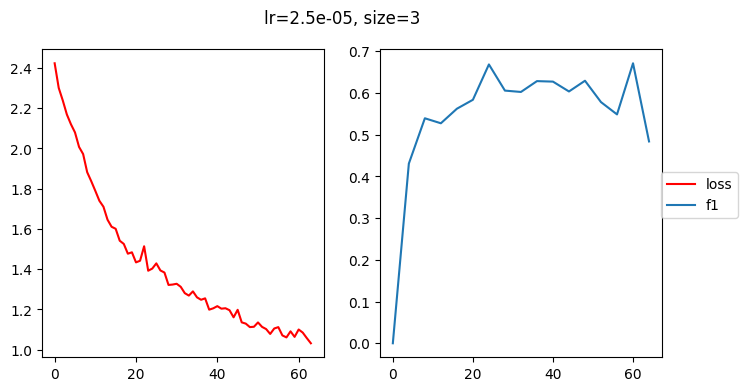

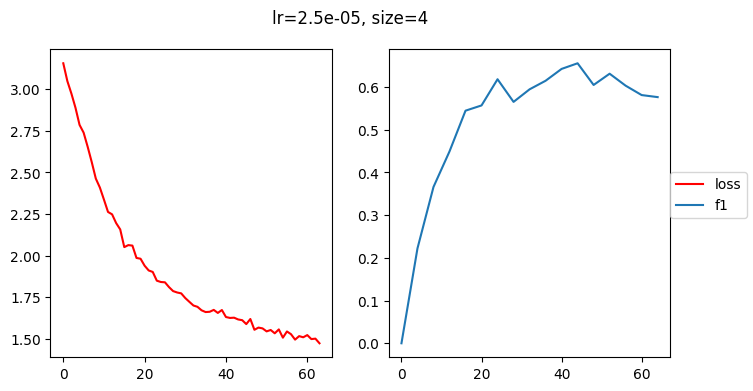

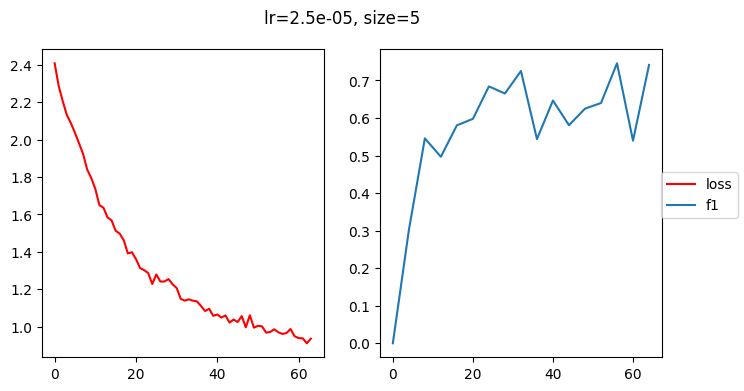

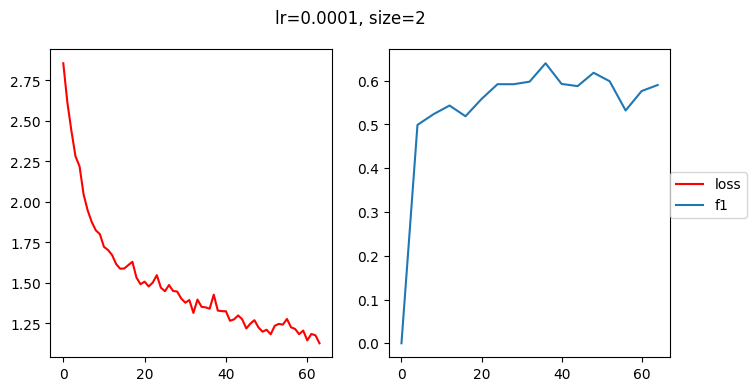

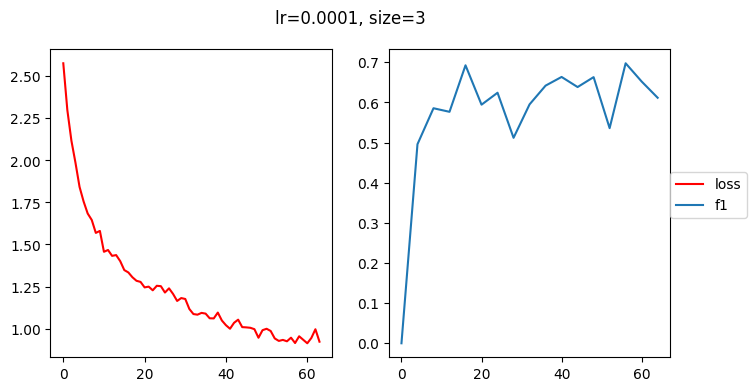

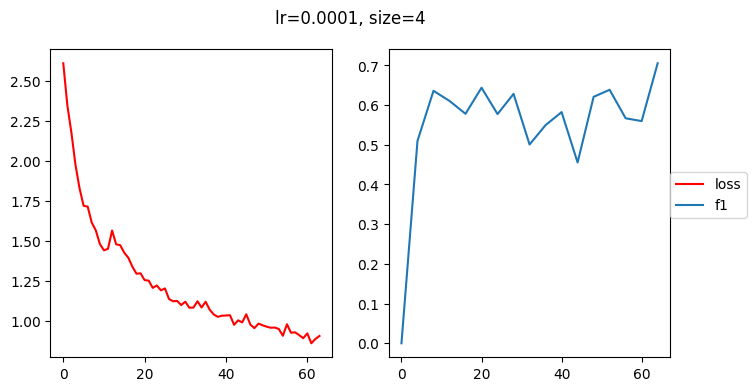

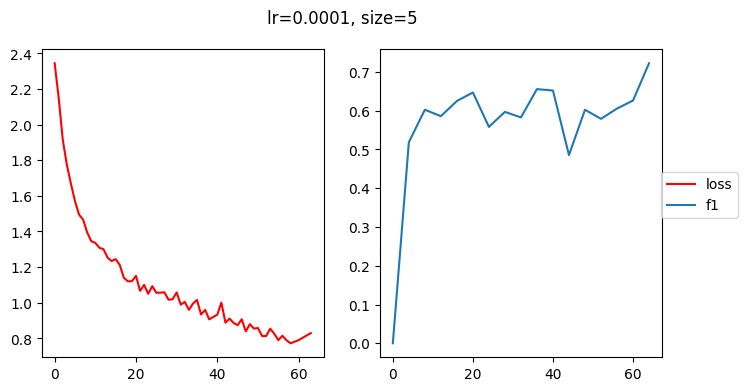

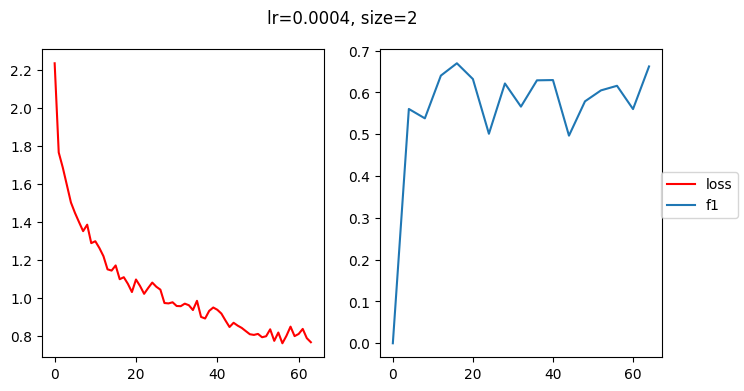

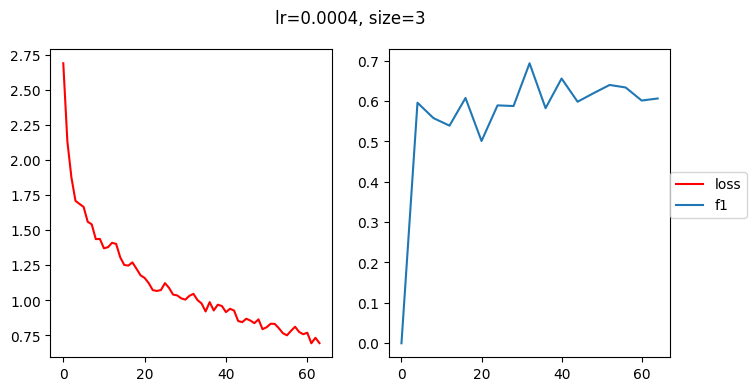

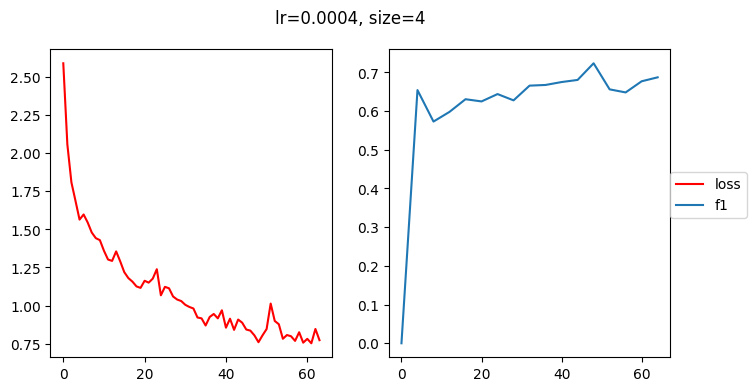

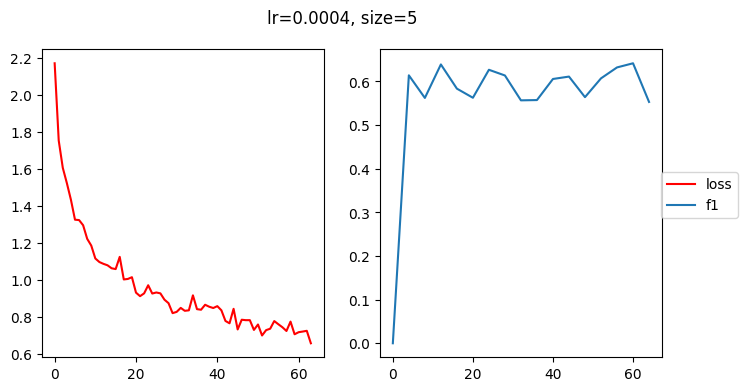

In [88]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Makes progressbar work on my machine
print()
# Initialize model
lrs = [2.5e-5, 1e-4, 4e-4]
model_feature_size = [2, 3, 4, 5]
stat_interval = 4

results = dict()

for lr in lrs:
    for size in model_feature_size:
        max_f1 = 0
        best_epoch = 0

        features = [64 * 2 ** i for i in range(size)]
        model = UNet(features=features).to(device)
        # Loss function, optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training
        num_epochs = 64
        losses = []
        f1s = [0]

        for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training", position=0, ):
            epoch_loss = 0
            for images, labels in train_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
            losses.append(epoch_loss)

            if (epoch + 1) % stat_interval == 0:
                # can't shadow function name from above
                f1_, iou_, acc_ = 0, 0, 0
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)

                        output = model(images)
                        output = torch.sigmoid(output)

                        stats = get_stats(output, labels, 0.5)
                        f1_ += f1(stats).sum().item()
                        iou_ += iou(stats).sum().item()
                        acc_ += pixel_accuracy(stats).sum().item()

                num_img = len(test_dataset)
                f1_ = f1_ / num_img
                f1s.append(f1_)
                if f1_ > max_f1:
                    max_f1 = f1_
                    best_epoch = epoch

        results[(lr, size)] = (max_f1, best_epoch)
        fig = plt.figure(figsize=(8, 4))
        (left, right) = fig.subplots(1, 2)
        left.plot(np.array(losses), label="loss", color="red")
        right.plot(np.arange(0, num_epochs + stat_interval, step=stat_interval), np.array(f1s), label="f1")
        # right.plot(np.arange(0, num_epochs + stat_interval, step=stat_interval), np.array(ious), label="iou")
        # right.plot(np.arange(0, num_epochs + stat_interval, step=stat_interval), np.array(accs), label="pixel accuracy")
        fig.legend(loc="center right")
        fig.suptitle(f"lr={lr}, size={size}")
        fig.show()


print(results)

In [89]:
for key in results.keys():

    (lr, size) = key
    (f1_, epoch) = results[key]
    print(f"lr: {lr}, size: {size}: f1: {f1_:.4}, epoch: {epoch}")

lr: 2.5e-05, size: 2: f1: 0.6301, epoch: 55
lr: 2.5e-05, size: 3: f1: 0.671, epoch: 59
lr: 2.5e-05, size: 4: f1: 0.6557, epoch: 43
lr: 2.5e-05, size: 5: f1: 0.7456, epoch: 55
lr: 0.0001, size: 2: f1: 0.6396, epoch: 35
lr: 0.0001, size: 3: f1: 0.6975, epoch: 55
lr: 0.0001, size: 4: f1: 0.7053, epoch: 63
lr: 0.0001, size: 5: f1: 0.7223, epoch: 63
lr: 0.0004, size: 2: f1: 0.6697, epoch: 15
lr: 0.0004, size: 3: f1: 0.6932, epoch: 31
lr: 0.0004, size: 4: f1: 0.7234, epoch: 47
lr: 0.0004, size: 5: f1: 0.6412, epoch: 59


## Training on full dataset

In [94]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader

train_dataset = LocalImageDataset(DATA_PATH,
                                  transform=v2.Compose([
                                      v2.ToImage(),
                                      v2.ToDtype(torch.float32, scale=True),
                                      v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), antialias=True),
                                      v2.RandomHorizontalFlip(p=0.5),
                                      v2.RandomVerticalFlip(p=0.5),
                                  ]),
                                  )
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)



In [121]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Makes progressbar work on my machine
print()
# Initialize model
model = UNet(features=[64*2**i for i in range(5)]).to(device)

# Loss function, optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-5)

# Training
num_epochs = 64
losses = []

#should divide num_epochs for plotting
stat_interval = 4
ious = [0]
f1s = [0]
accs = [0]

for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training", position=0, ):
    epoch_loss = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss)
    if (epoch + 1) % stat_interval == 0:
        # can't shadow function name from above
        f1_, iou_, acc_ = 0, 0, 0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            output = torch.sigmoid(output)

            stats = get_stats(output, labels, 0.5)
            f1_ += f1(stats).sum().item()
            iou_ += iou(stats).sum().item()
            acc_ += pixel_accuracy(stats).sum().item()
        f1s.append(f1_ / len(train_dataloader) / train_dataloader.batch_size)
        ious.append(iou_ / len(train_dataloader) / train_dataloader.batch_size)
        accs.append(acc_ / len(train_dataloader) / train_dataloader.batch_size)



Training: 100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


[0, 0.3341079902648926, 0.6659827518463135, 0.7325808429718018, 0.8030113506317139, 0.8243412113189696, 0.857088279724121, 0.8674733352661133, 0.871517276763916, 0.9077693557739257, 0.9013608932495117, 0.9226607131958009, 0.9038888549804687, 0.8896179103851318, 0.9335757064819337, 0.9234873199462891, 0.9206963920593262]


C:\Users\julia\AppData\Local\Temp\ipykernel_44708\2873494267.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


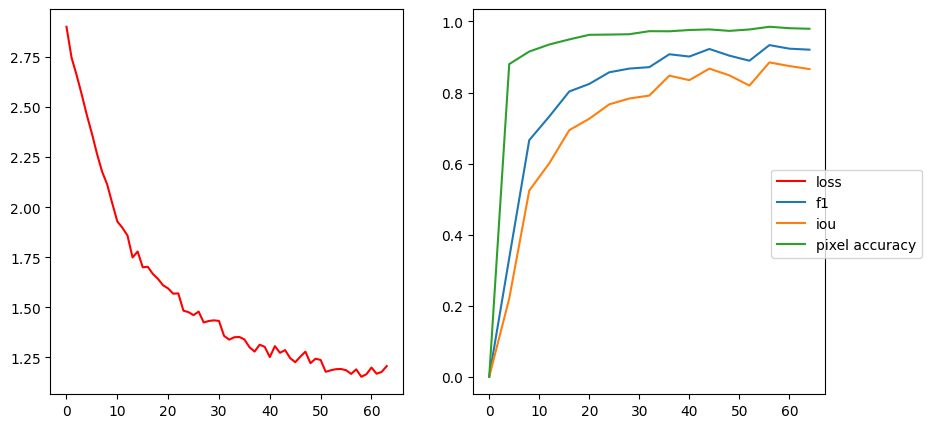

In [123]:
print(f1s)
fig = plt.figure(figsize=(10, 5))
(left, right) = fig.subplots(1, 2)
left.plot(np.array(losses), label="loss", color="red")
right.plot(np.arange(0, num_epochs+1, step=stat_interval), np.array(f1s), label="f1")
right.plot(np.arange(0, num_epochs+1, step=stat_interval), np.array(ious), label="iou")
right.plot(np.arange(0, num_epochs+1, step=stat_interval), np.array(accs), label="pixel accuracy")
fig.legend(loc="center right")
fig.show()


torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([256, 256])


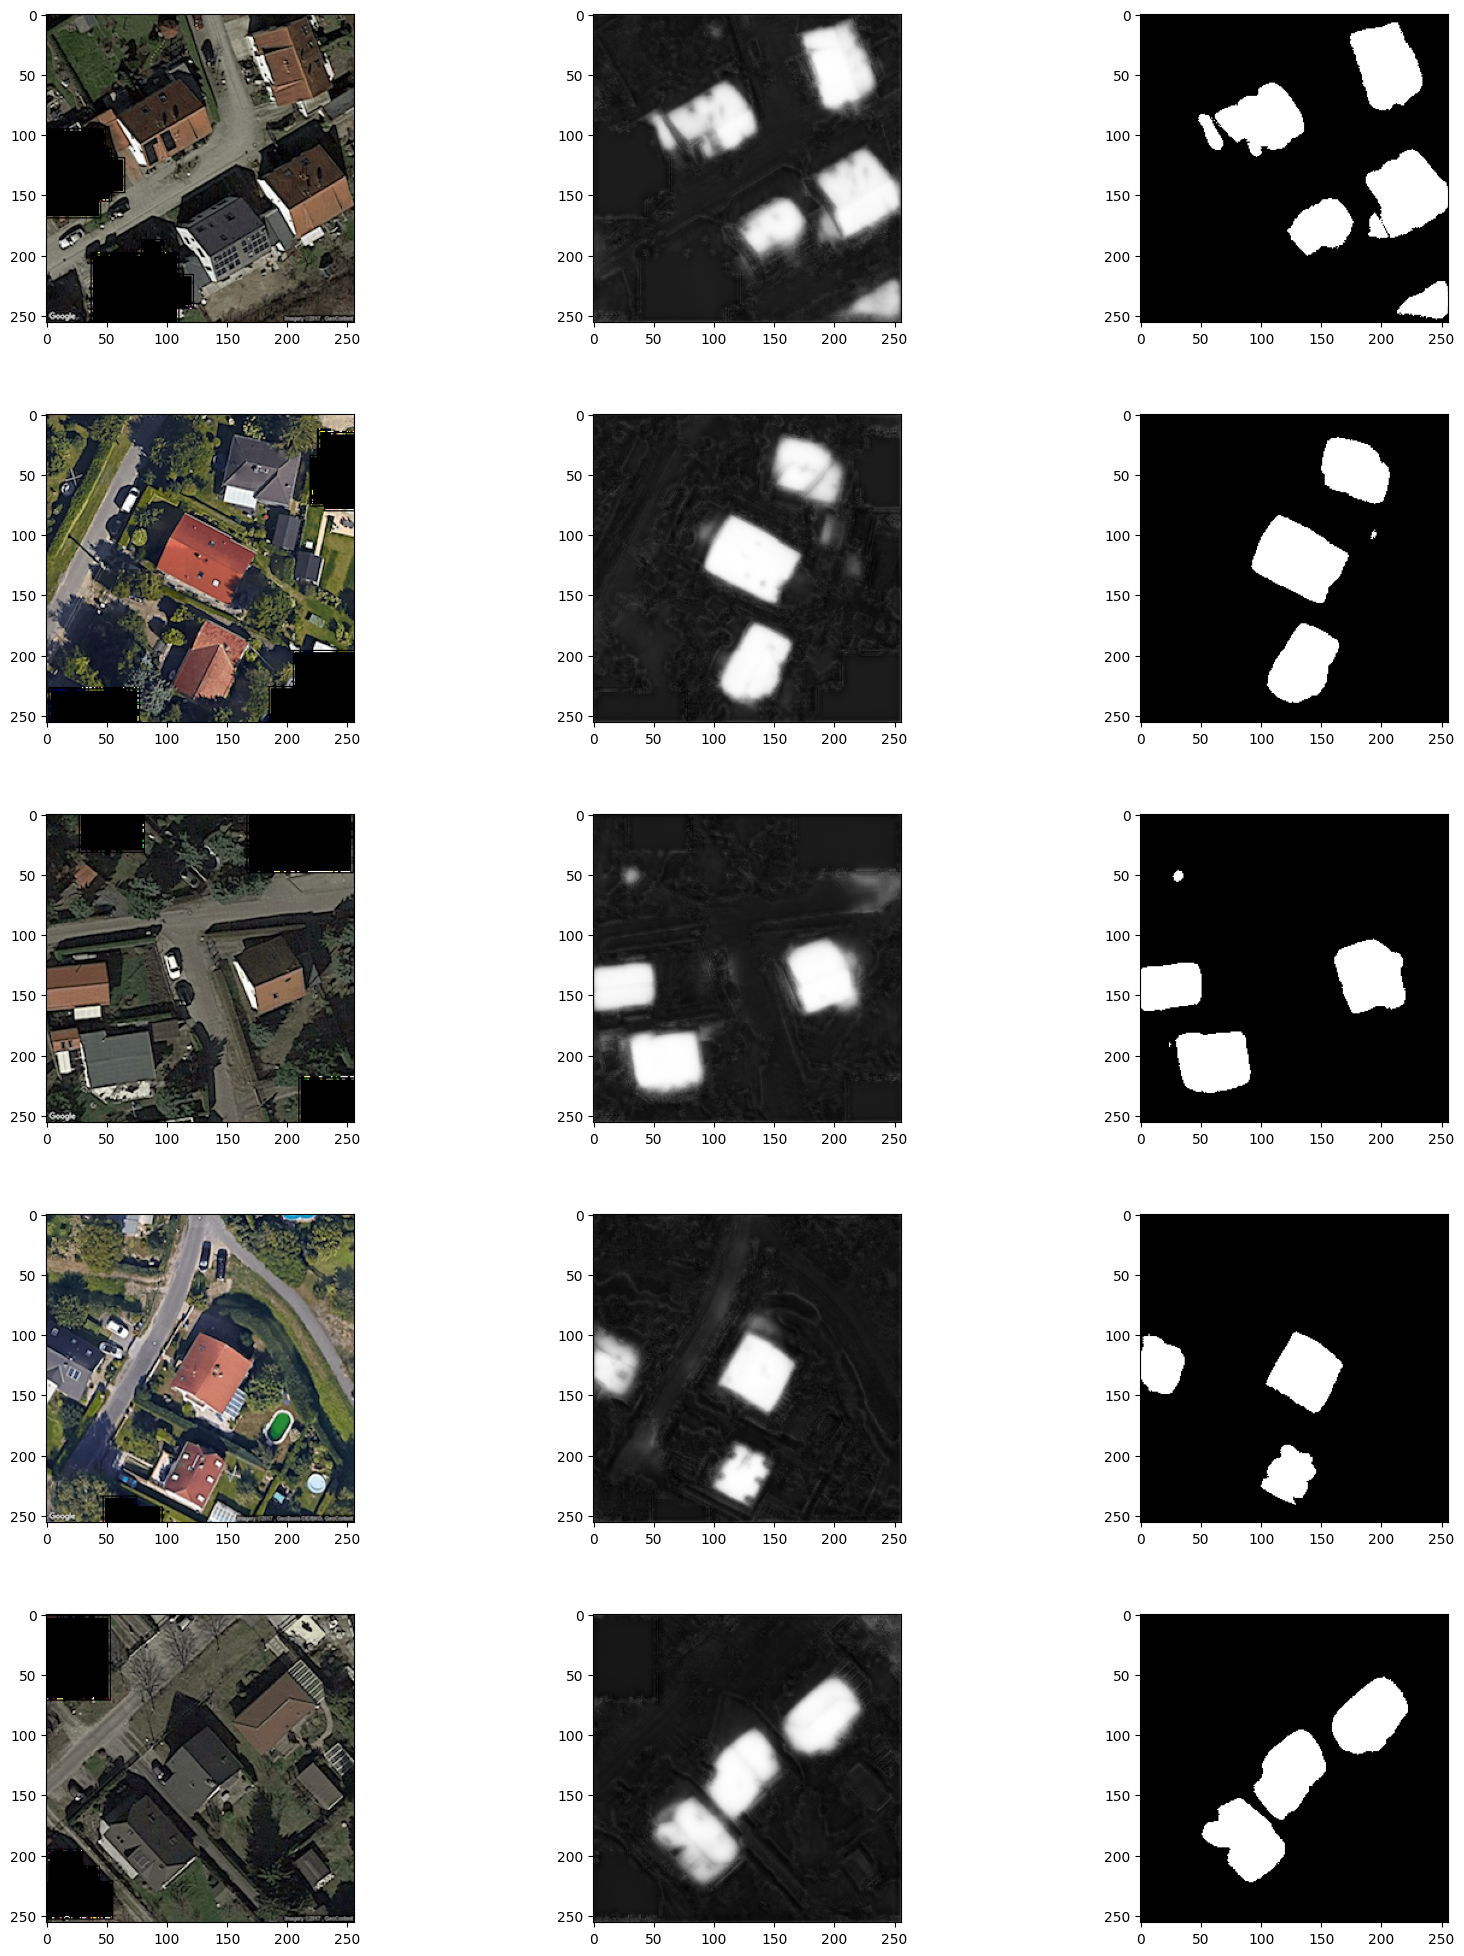

In [124]:
import torch
from torchvision.transforms import v2
from PIL import Image

test_dataset = LocalImageDataset(DATA_PATH, test=True, transform=v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
]))

model.eval()
fig = plt.figure(figsize=(20,20))
subfigs = fig.subfigures(len(test_dataset), 1)
for (i, (image, _)) in enumerate(test_dataset):
    subfig = subfigs[i]
    (left, center, right) = subfig.subplots(1,3)
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        output = torch.sigmoid(output)
        output = output.squeeze()
        binary = torch.where((output > 0.5), 1.0, 0.0)

    left.imshow(image.permute((1,2,0)).numpy())
    center.imshow(output.cpu().numpy(), cmap="grey")
    right.imshow(binary.cpu().numpy(), cmap="grey")
